In [1]:
from dist_tools import *

# import re
# import scipy
# import math
# import shapely
# from shapely import wkt
# from shapely.geometry import Point

# from scipy.spatial import Voronoi, voronoi_plot_2d
# from sklearn.decomposition.pca import PCA

# from scipy.stats import norm
# import statsmodels.api as sm
# import statsmodels.discrete.discrete_model as sm_dm

# from scc import *  ## Nayuki minimum bounding circle, instead of miniball.

%matplotlib inline

Optimization terminated successfully.
         Current function value: 0.146857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170656
         Iterations 7


/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
def ctr(group, w):
    
    p = group[w]
    xctr = (group["x"] * p).sum() / p.sum()
    yctr = (group["y"] * p).sum() / p.sum()
    
    return Point([xctr, yctr])


def avg_interperson_distance(group):

    dist2 =  scipy.spatial.distance.cdist(group[["x", "y"]].as_matrix(),
                                          group[["x", "y"]].as_matrix(),
                                          metric = 'euclidean')

    interp_dist = np.dot(np.dot(group["pop"], dist2), group["pop"]) / \
                  np.dot(group["pop"][:,np.newaxis], group["pop"][np.newaxis,:]).sum()

    return interp_dist # * 0.000621371 # meters to miles


def normed_inertia(group, d, w):

    I = (group[d]**2 * group[w]).sum()
    In = group["area"].sum() * group[w].sum() / 2 / math.pi

    return In / I 


def R_circumscribing(group): return make_circle([xy for xy in zip(group["x"], group["y"])])[2]

def R_mean(group): return (group["area"] * group["dctr"]).sum() / group["area"].sum()
def R_dyn(group):  return np.sqrt((group["area"] * group["dctr"]**2).sum() / group["area"].sum())
def R_harm(group): return group["area"].sum() / (group["area"] / group["dctr"]).sum()

def get_points(x):
    
    l = x if type(x) is shapely.geometry.multipolygon.MultiPolygon else [x]
    
    pts = []
    for poly in l:
        for pt in poly.exterior.coords:
            pts.append(pt)
        for ir in poly.interiors:
            for pt in ir.coords:
                pts.append(pt)

    return pts


def get_lic(poly):
    
    # simp = poly.simplify(100)
    pts = get_points(poly)

    # print(pts)
    vor = Voronoi(pts)

    max_d2, lic_ctr, lic_r = 0, 0, 0
    for vtxi, vtx in enumerate(vor.vertices):

        if not poly.contains(Point(vtx)):
            continue

        region = [ri for ri, r in enumerate(vor.regions) if vtxi in r][0]

        source = None
        for pti, pt_reg in enumerate(vor.point_region):
            if region == pt_reg: 
                source = vor.points[pti]
                break

        d2 = (vtx[0] - source[0])**2 + (vtx[1] - source[1])**2

        if d2 > max_d2:

            max_d2 = d2
            lic_ctr, lic_r = tuple(vtx), math.sqrt(d2)

    return lic_ctr, lic_r


def get_lic_circ(poly):

    ctr, R = get_lic(poly)
    return Point(ctr).buffer(R)
    
def R_inscribed(poly): return get_lic(poly)[1]

def get_exchange_area(poly):
    
    R = math.sqrt(poly.area/math.pi)
    return poly.intersection(Point(poly.centroid).buffer(R))

def exchange(poly):
    
    R = math.sqrt(poly.area/math.pi)
    return poly.intersection(Point(poly.centroid).buffer(R)).area / poly.area

def axis_ratio(group):

    pca = PCA()
    pca.fit(group[["x", "y"]])
    
    return pca.explained_variance_[1]/pca.explained_variance_[0]


def rohrbach(group):
    
    obj = (group["dperim"] * group["area"]).sum()
    R3 = math.pow(group["area"].sum()/math.pi, 3/2)
                  
    return obj / (math.pi * R3/3)

def get_state_info(usps):
    
    st = pd.read_sql("select seats, epsg, lower(usps) usps, fips from states where usps = upper('{}');".format(usps),
                     con = psycopg2.connect(database = "census", user = user, password = passwd,
                                            host = "saxon.harris.uchicago.edu", port = 5432)).loc[0].to_dict()

    return st["epsg"], st["fips"], st["seats"]


def get_state_cd_map(usps, session, year, epsg):

    cd_gdf = gpd.GeoDataFrame.from_postgis("""SELECT cd, ST_Transform(cd.geom, epsg) geometry
                                              FROM cd JOIN states ON cd.state = fips
                                              WHERE states.usps = UPPER('{}') and sessn = {};""".format(usps, session),
                                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                                  host = "saxon.harris.uchicago.edu", port = 5432),
                                           geom_col = "geometry", crs = from_epsg(epsg), index_col = "cd")
    
    cd_gdf["usps"] = usps.upper()
    cd_gdf["congress"] = session
    cd_gdf["year"] = year
    
    return cd_gdf


def get_state_tracts(usps, year = 2015):

    tr_gdf = gpd.GeoDataFrame.from_postgis("""SELECT rn, pop, 
                                                     ST_Area(ST_Transform(tr.geom, epsg)) area,
                                                     ST_Centroid(ST_Transform(tr.geom, epsg)) geometry,
                                                     ST_AsText(ST_Transform(tr.geom, epsg)) shape,
                                                     ST_X(ST_Centroid(ST_Transform(tr.geom, epsg))) x, 
                                                     ST_Y(ST_Centroid(ST_Transform(tr.geom, epsg))) y
                                              FROM census_tracts_{} tr, states,
                                                   (SELECT
                                                      state, county, tract,
                                                      row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 AS rn
                                                    FROM census_tracts_2015) rn
                                              WHERE 
                                                rn.state = tr.state AND rn.county = tr.county AND rn.tract = tr.tract AND
                                                tr.state = fips AND states.usps = UPPER('{}');""".format(year, usps),
                                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                                  host = "saxon.harris.uchicago.edu", port = 5432),
                                           geom_col = "geometry", index_col = "rn", crs = from_epsg(epsg))

    tr_gdf["shape"] = gpd.GeoSeries(tr_gdf["shape"].apply(wkt.loads))

    return tr_gdf


def evaluate_state(cd_gdf, tr_gdf):
    
    tr_gdf = gpd.tools.sjoin(tr_gdf, cd_gdf.reset_index(), op = "within")
    tr_gdf = tr_gdf.reset_index()[["cd", "pop", "area", "x", "y", "geometry", "shape"]]

    tr_gdf = tr_gdf.merge(pd.DataFrame({"ctr"  : tr_gdf.groupby("cd").apply(ctr, w = "area"),
                                        "pctr" : tr_gdf.groupby("cd").apply(ctr, w = "pop")}).reset_index(), on = "cd")

    tr_gdf["dctr"] = tr_gdf.distance(tr_gdf.set_geometry("ctr"))
    tr_gdf["dpctr"] = tr_gdf.distance(tr_gdf.set_geometry("pctr"))

    boundaries = shapely.ops.unary_union(cd_gdf.boundary)
    tr_gdf["dperim"] = tr_gdf.distance(boundaries)

    tr_cd_group = tr_gdf.groupby("cd")

    cd_gdf["ctr"]        = gpd.GeoSeries(tr_cd_group.apply(ctr, w = "area"))
    cd_gdf["pctr"]       = gpd.GeoSeries(tr_cd_group.apply(ctr, w = "pop"))

    cd_gdf["R_isoa"]     = np.sqrt(cd_gdf.area / math.pi)
    cd_gdf["R_isop"]     = cd_gdf.length / (2 * math.pi)
    cd_gdf["R_LIC"]      = cd_gdf.geometry.apply(R_inscribed)
    cd_gdf["R_SCC"]      = tr_cd_group.apply(R_circumscribing)
    cd_gdf["R_mean"]     = tr_cd_group.apply(R_mean)
    cd_gdf["R_harm"]     = tr_cd_group.apply(R_harm)
    cd_gdf["R_dyn"]      = tr_cd_group.apply(R_dyn)

    dist_pop = gpd.tools.sjoin(cd_gdf, tr_gdf, op = "contains")[["cd", "pop"]]
    hull_pop = gpd.tools.sjoin(cd_gdf.set_geometry(cd_gdf.convex_hull).reset_index(), 
                               tr_gdf[["geometry", "pop"]], op = "contains")[["cd", "pop"]]
    cd_gdf["pop"] = dist_pop.groupby("cd").sum()
    cd_gdf["pop_hull"]   = hull_pop.groupby("cd").sum()

    state_mp = shapely.ops.unary_union(list(cd_gdf.geometry))
    cd_gdf["A_hull"]     = cd_gdf.convex_hull.intersection(state_mp).area

    cd_gdf["IP_d"]       = tr_cd_group.apply(avg_interperson_distance)

    cd_gdf["obj_ip_dist"]     = (128 * cd_gdf.R_isoa / (45 * math.pi)) / cd_gdf.IP_d
    cd_gdf["obj_polsby"]      = 4 * math.pi * cd_gdf.area / cd_gdf.length**2
    cd_gdf["obj_lic"]         = (math.pi * cd_gdf["R_LIC"] ** 2) / cd_gdf.area
    cd_gdf["obj_scc"]         = cd_gdf.area / (math.pi * cd_gdf["R_SCC"] ** 2)
    cd_gdf["obj_inertia_a"]   = tr_cd_group.apply(normed_inertia, w = "area", d = "dctr")
    cd_gdf["obj_inertia_p"]   = tr_cd_group.apply(normed_inertia, w = "pop", d = "dpctr")
    cd_gdf["obj_mean_radius"] = (2 * cd_gdf.R_isoa / 3) / cd_gdf.R_mean
    cd_gdf["obj_harm_radius"] = (cd_gdf.R_isoa / 2) / cd_gdf.R_harm
    cd_gdf["obj_dyn_radius"]  = (cd_gdf.R_isoa / math.sqrt(2)) / cd_gdf.R_dyn
    cd_gdf["obj_axis"]        = tr_gdf.groupby("cd").apply(axis_ratio)
    cd_gdf["obj_exchange"]    = cd_gdf.geometry.apply(exchange)
    cd_gdf["obj_hull_pop"]    = cd_gdf["pop"] / cd_gdf["pop_hull"]
    cd_gdf["obj_hull_area"]   = cd_gdf.area / cd_gdf["A_hull"]
    cd_gdf["obj_rohrbach"]    = tr_cd_group.apply(rohrbach)


In [3]:
def efficiency_gap_rep(cd_gdf, tr_gdf):
    
    tr = gpd.tools.sjoin(tr_gdf, cd_gdf[["geometry"]].reset_index(), op = "within")
    cd = tr.filter(regex = "cd|^[DR][901][02468]$").groupby("cd").sum()
    
    years = [x[1:] for x in list(cd.filter(regex = "^D").columns)]
    
    EG = {}
    for y in years:
        cd["D" + y + "_waste"] = np.where(cd["D" + y] > cd["R" + y], cd["D" + y] - 0.5 * (cd["R" + y] + cd["D" + y]), cd["D" + y])
        cd["R" + y + "_waste"] = np.where(cd["R" + y] > cd["D" + y], cd["R" + y] - 0.5 * (cd["R" + y] + cd["D" + y]), cd["R" + y])
        egy = cd.filter(regex = y + "_waste").sum()/(cd["D" + y].sum() + cd["R" + y ].sum())
        EG[int(y)] = egy["R" + y + "_waste"] - egy["D" + y + "_waste"]
    
    return sum(EG.values()) / len(years)

In [4]:
min_rep = pd.read_csv("min_rep.csv")
min_rep = min_rep[min_rep.Session == 115].copy(deep = True)
min_rep.reset_index(drop = True, inplace = True)

probit_b = sm_dm.Probit(min_rep["BRep"], min_rep[["BFrac", "const"]]).fit()
probit_h = sm_dm.Probit(min_rep["HRep"], min_rep[["HFrac", "const"]]).fit()

def minority_seats(cd_gdf, tr_gdf):
    
    tr = gpd.tools.sjoin(tr_gdf, cd_gdf[["geometry"]].reset_index(), op = "within")
    cd = tr.filter(regex = "cd|vap").groupby("cd").sum()
    
    cd["BFrac"]  = cd["black_vap"]    / cd["total_vap"]
    cd["BSeats"] = norm.sf(- (cd["BFrac"] * probit_b.params["BFrac"] + probit_b.params.const))

    cd["HFrac"]  = cd["hispanic_vap"] / cd["total_vap"]
    cd["HSeats"] = norm.sf(- (cd["HFrac"] * probit_h.params["HFrac"] + probit_h.params.const))

    # print(cd["BSeats"].sum(), cd["HSeats"].sum())

    return cd["BSeats"].sum() + cd["HSeats"].sum()
    

Optimization terminated successfully.
         Current function value: 0.146857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170656
         Iterations 7


In [20]:
dec = pd.read_csv("decennial_compactness.csv")

pca = PCA(n_components = 2)
pca.fit(dec.filter(regex = "^obj"))
cols = list(dec.filter(regex = "^obj").columns)

In [2]:
columns = {'cd': "ID", "pop_ratio" : "Pop./Target", "a_sq_mi" : 'Area [sq mi]', 
           "obj_dyn_radius": 'DynamicRadius', "obj_polsby" : 'IPQ', 
           "obj_axis" : 'AxisRatio', "obj_exchange" : 'Exchange', "obj_lic" : 'InscrCircle', 
           "obj_harm_radius" : 'HarmonicRadius', "obj_inertia_a" : 'InertiaArea',
           "obj_mean_radius" : 'MeanRadius', "obj_scc" : 'CircCircle', "obj_hull_pop" : 'HullPop',
           "obj_inertia_p" : 'InertiaPop',
           "obj_rohrbach" : 'DistPerimeter', "obj_hull_area" : 'HullArea'}

In [5]:
metrics = pd.DataFrame()

for year, sessn in [[1990, 107], [2000, 111], [2010, 114]]:
    for usps in ["pa"]: # us_states[:1]:

        epsg, fips, seats = get_state_info(usps)
        if seats == 1: continue

        print(usps, year, sessn, seats, epsg, fips)

        cd_gdf = get_state_cd_map(usps, sessn, year, epsg)
        tr_gdf = get_state_tracts(usps, year, epsg)
        evaluate_state(cd_gdf, tr_gdf)
        metrics = metrics.append(cd_gdf.to_crs(epsg = 2163))
        
    output_geojson(cd_gdf.reset_index().rename(columns = columns)[list(columns.values()) + ["geometry"]],
                   "cd/{}_{}.geojson".format(usps, sessn))
        
metrics = metrics.reset_index()
# metrics

pa 1990 107 18 3364 42
pa 2000 111 18 3364 42
pa 2010 114 18 3364 42


In [3]:
cd_gdf.columns

Index(['geometry', 'usps', 'congress', 'year', 'ctr', 'pctr', 'R_isoa',
       'R_isop', 'R_LIC', 'R_SCC', 'R_mean', 'R_harm', 'R_dyn', 'pop',
       'pop_hull', 'A_hull', 'IP_d', 'obj_ip_dist', 'obj_polsby', 'obj_lic',
       'obj_scc', 'obj_inertia_a', 'obj_inertia_p', 'obj_mean_radius',
       'obj_harm_radius', 'obj_dyn_radius', 'obj_axis', 'obj_exchange',
       'obj_hull_pop', 'obj_hull_area', 'obj_rohrbach', 'pop_ratio',
       'a_sq_mi'],
      dtype='object')

In [3]:
usps, year, sessn, seats, epsg, fips = "al", 1990, 107, 7, 3465, 1

cd_gdf = get_state_cd_map(usps, sessn, year, epsg)
tr_gdf = get_state_tracts(usps, year, epsg)
evaluate_state(cd_gdf, tr_gdf)

In [10]:
usps, session, year = "nc", 114, 2010
epsg, fips, seats = get_state_info(usps)

In [2]:
metrics = pd.DataFrame()

infile, comp, eg, mseats = [], [], [], []
for year, sessn in [[1990, 107], [2000, 111], [2010, 114]]:
    for usps in us_states:

        epsg, fips, seats = get_state_info(usps)
        if seats == 1: continue

        print(usps, year, sessn, seats, epsg, fips)

        cd_gdf = get_state_cd_map(usps, sessn, year, epsg)
        tr_gdf = get_state_tracts(usps, year, epsg)
        evaluate_state(cd_gdf, tr_gdf)

        cd_gdf['obj_pca1'] = pca.transform(cd_gdf[cols])[:,0]
        cd_gdf['obj_pca2'] = pca.transform(cd_gdf[cols])[:,1]

        infile.append(re.sub(r".*res/([0-9a-z/_]*)/final.*", r"\1", f))
        comp.  append(cd_gdf['obj_pca1'].mean())
#         eg.    append(efficiency_gap_rep(cd_gdf, tr_gdf))
#         mseats.append(minority_seats(cd_gdf, tr_gdf))

        metrics = metrics.append(cd_gdf.to_crs(epsg = 2163))
    
        output_geojson()
        
metrics = metrics.reset_index()
# metrics

al 1990 107 7 3465 1


NameError: name 'f' is not defined

In [21]:
pop.head()

,Compactness,EG,File,Seats
0,0.409219,-0.060550,nc/power/s000/c000,2.412620
1,0.454208,-0.033487,nc/power/s000/c001,2.436888
2,0.426907,0.013762,nc/power/s000/c002,2.418983
3,0.459920,-0.038065,nc/power/s000/c003,2.460943
4,0.468917,-0.071591,nc/power/s000/c004,2.510565


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121ae7c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12224ccf8>]], dtype=object)

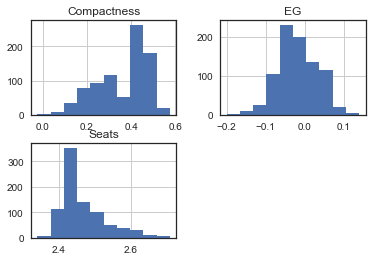

In [23]:
pop.hist()

In [12]:
scores = pd.concat(nc_cd_dist).groupby("map").mean()
scores.filter(regex = "^obj_").to_csv(usps + "_scores.csv")

In [13]:
# sns.regplot(x = scores["obj_ip_dist"], y = scores["obj_pca1"])
max_score = scores["obj_pca1"].max()

In [14]:
nc_test = gpd.read_file("nc_harmonic_radius.geojson").to_crs(epsg = epsg)
nc_test["cd"] = nc_test.id.astype(int)
nc_test = nc_test.set_index("cd")[["geometry"]]

evaluate_state(nc_test, nc_tr)

In [15]:
efficiency_gap_rep(nc_test, nc_tr) 

-0.059294440706446017

In [16]:
minority_seats(nc_test, nc_tr)

2.3922197512308117

In [17]:
nc_test['obj_pca1'] = pca.transform(nc_test[cols])[:,0]
nc_test['obj_pca1'].mean()

0.2898759713521533

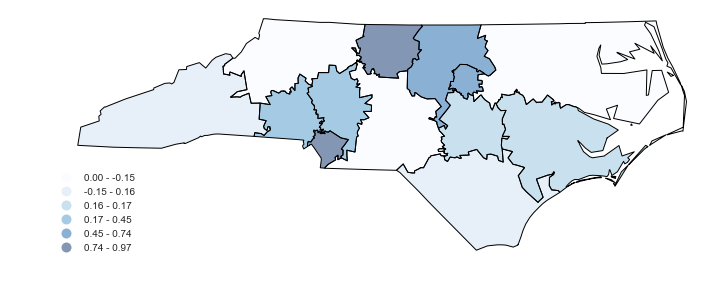

In [18]:
nc_test.plot(column = "obj_pca1", 
             cmap = "Blues", scheme = "quantiles", k = 6, 
             figsize = (12, 8), legend = True).set_axis_off()